In [126]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_style("darkgrid")
sns.set_style('white')
sns.set_palette('deep')

In [2]:
df = pd.read_csv('candy-production-data.csv', header=0, names=['date','production'])
df['date']= pd.to_datetime(df['date'])

## Split the data
To keep things simple, I'm just using the last full year as the test set. I removed the incomplete year of 2021.

In [3]:
df_train = df[0:576]
df_test = df[576:588]

### A first look at the training data
Definitely very cyclical. Nice upward trend, but it was interruped pretty severely a few years ago. I'm interested to look into that a bit more.

<AxesSubplot:>

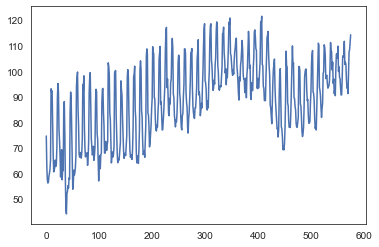

In [127]:
df_train['production'].plot(kind='line')

## Deseasonalizing the data

In [7]:
df_train.head()

,date,production,year,month
0,1972-01-01,74.6609,1972,1
1,1972-02-01,62.5732,1972,2
2,1972-03-01,57.5207,1972,3
3,1972-04-01,56.2487,1972,4
4,1972-05-01,56.6349,1972,5


In [6]:
# Create year and month variables
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month

# First, get the seasonal average by taking the average monthly production for each year
annual_seasonal_avgs = df_train.groupby('year')['production'].mean()

# Merge annual averages with training data
df_train = df_train.merge(annual_seasonal_avgs, how='left', on='year')
df_train['seasonal_index'] = df_train['production_x']/df_train['production_y']

# Next, calculate the overall seasonal index for each season by taking the
# average of each month (e.g. take the average of all the January months)
overall_seasonal_indices = df_train.groupby('month')['seasonal_index'].mean()
df_train = df_train.merge(overall_seasonal_indices, how='left', on='month')

# Add the deseasonalized data to the training data
df_train['deseasonalized_data'] = df_train['production_x']/df_train['seasonal_index_y']

# Rename columns because they are getting confusing!
df_train.rename(columns={'production_x':'production'
                        ,'production_y':'annual_seasonal_average'
                        ,'seasonal_index_x':'annual_seasonal_index'
                        ,'seasonal_index_y':'monthly_seasonal_index'}
                        ,inplace=True)

# Add trend component by taking the 12-month rolling average of the mean
df_train['trend'] = df_train['deseasonalized_data'].rolling(12).mean()
# Note to self: I took the 12-month rolling average on the production data as well. It didn't make much difference, so I just stuck with this.

<ipython-input-6-6af1b312489d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['year'] = df_train['date'].dt.year
<ipython-input-6-6af1b312489d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['month'] = df_train['date'].dt.month


In [50]:
df_train.head()

,date,production,year,month,annual_seasonal_average,annual_seasonal_index,monthly_seasonal_index,deseasonalized_data,trend
0,1972-01-01,74.6609,1972,1,69.262708,1.077938,1.025387,72.812430,NaN
1,1972-02-01,62.5732,1972,2,69.262708,0.903418,0.983525,63.621386,NaN
2,1972-03-01,57.5207,1972,3,69.262708,0.830471,0.918715,62.609944,NaN
3,1972-04-01,56.2487,1972,4,69.262708,0.812107,0.879247,63.973728,NaN
4,1972-05-01,56.6349,1972,5,69.262708,0.817682,0.881116,64.276320,NaN


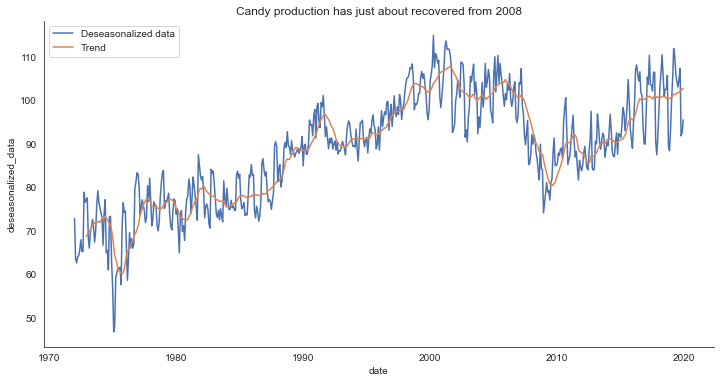

In [128]:
# Plot the deseasonalized data and trend

fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=df_train, x='date', y='deseasonalized_data')
sns.lineplot(data=df_train, x='date', y='trend')
plt.legend(['Deseasonalized data', 'Trend'])
plt.title('Candy production has just about recovered from 2008')
sns.despine()

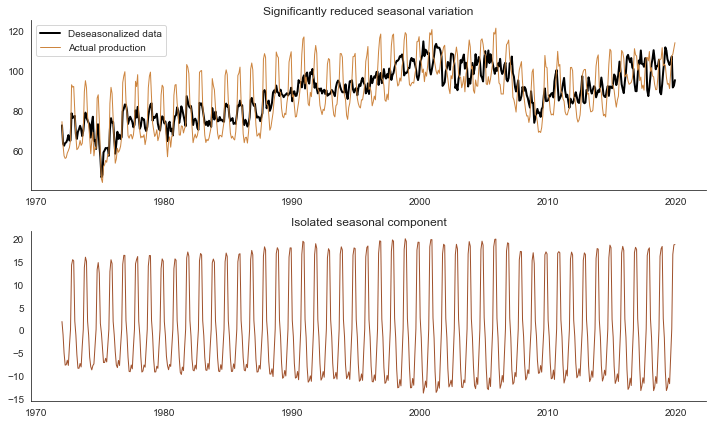

In [134]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6))

ax1.plot(df_train['date'], df_train['deseasonalized_data'], linewidth=2, color='black')
ax1.plot(df_train['date'], df_train['production'], linewidth=1, color='peru')
ax1.legend(['Deseasonalized data', 'Actual production'])
ax1.title.set_text('Significantly reduced seasonal variation')

ax2.plot(df_train['date'], df_train['production']-df_train['deseasonalized_data'], linewidth=1, color='sienna')
ax2.title.set_text('Isolated seasonal component')

sns.despine()
plt.tight_layout()

## You can stop here for now

Everything past this is older stuff I still need to clean up

In [12]:
df_decomp = df_train
df_decomp.set_index('date', inplace=True)

In [13]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_decomp['production'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df_decomp['production'], model='additive', extrapolate_trend='freq')


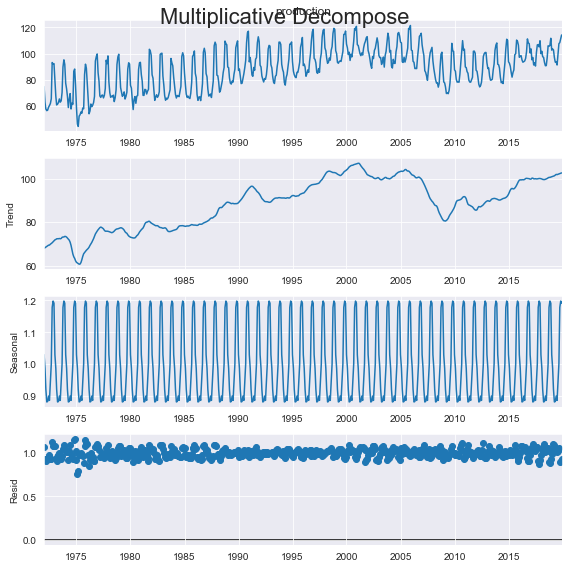

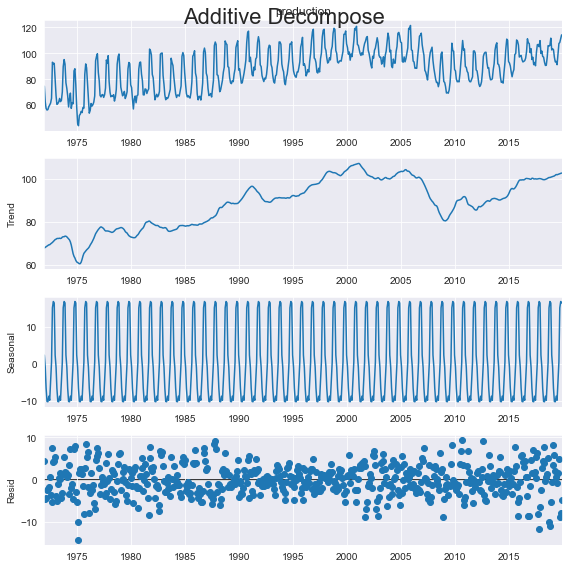

In [27]:
# Plot
plt.rcParams.update({'figure.figsize': (8,8)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

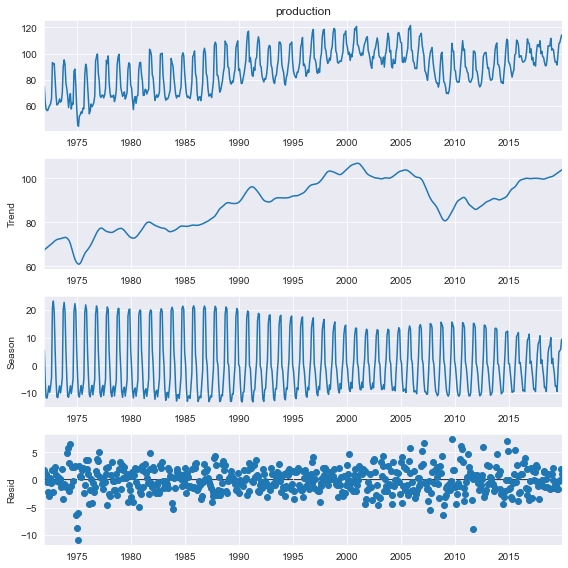

In [22]:
# STL Decomposition
stl = STL(df_decomp['production'], seasonal=13)
res = stl.fit()
fig = res.plot()

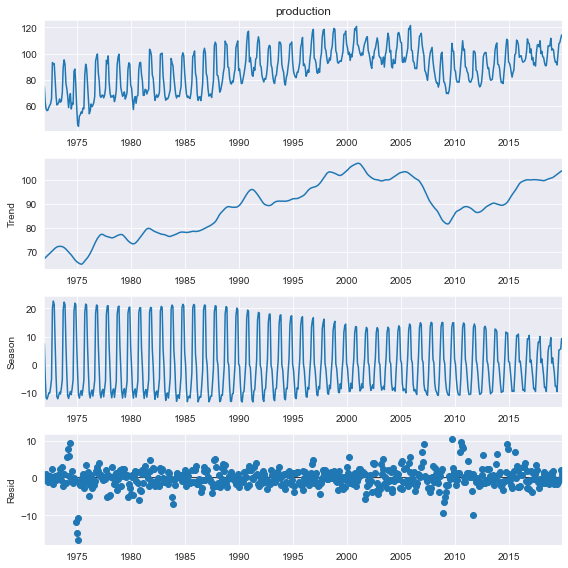

In [24]:
# STL Decomposition
stl = STL(df_decomp['production'], seasonal=13, robust=True)
res = stl.fit()
fig = res.plot()

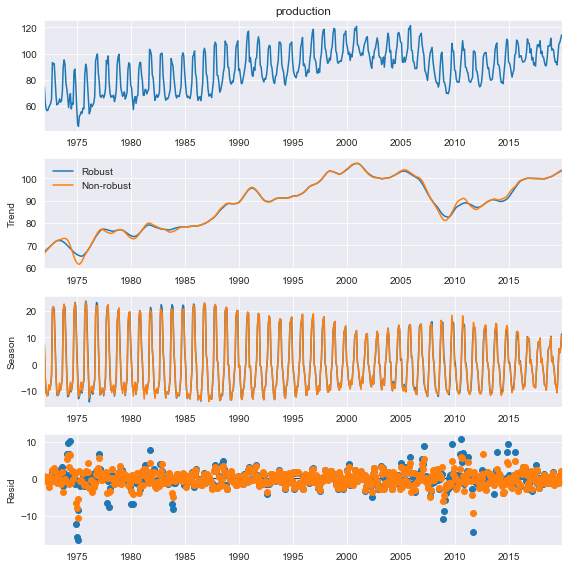

In [25]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)


stl = STL(df_decomp['production'], period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(df_decomp['production'], period=12, robust=False).fit()
add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

C:\Users\ericd\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ericd\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ericd\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


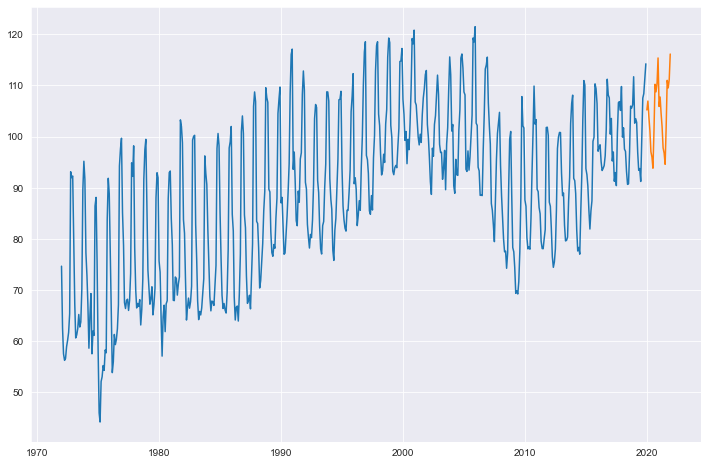

In [45]:
# elec_equip.index.freq = elec_equip.index.inferred_freq
stlf = STLForecast(df_decomp['production'], ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(24)

plt.rcParams.update({'figure.figsize': (12,8)})
plt.plot(df_decomp)
plt.plot(forecast)
plt.show()

In [46]:
print(stlf_res.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                  576
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1285.819
Date:                Thu, 14 Oct 2021   AIC                           2577.638
Time:                        19:45:27   BIC                           2590.701
Sample:                    01-01-1972   HQIC                          2582.732
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0638      0.078      0.815      0.415      -0.090       0.217
ar.L1         -0.2262      0.038     -5.919      0.000      -0.301      -0.151
sigma2         5.1266      0.225     22.828      0.0